In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

rng = np.random.default_rng(42)
data_path = Path("data/train.csv")

if data_path.exists():
    df_train = pd.read_csv(data_path)
    source_msg = "Dataset cargado desde data/train.csv"
else:
    n_samples = 800
    df_train = pd.DataFrame({
        "age": rng.normal(45, 10, n_samples).clip(18, 80),
        "income": rng.lognormal(mean=10.5, sigma=0.5, size=n_samples),
        "loan_amount": rng.normal(120000, 30000, n_samples).clip(20000, 300000),
        "num_late_payments": rng.poisson(1.2, n_samples),
        "credit_score": rng.normal(650, 50, n_samples).clip(300, 850),
    })
    df_train["loan_income_ratio"] = df_train["loan_amount"] / df_train["income"]
    logits = (
        -6
        + 0.8 * df_train["loan_income_ratio"]
        + 0.6 * (df_train["num_late_payments"] > 0)
        - 0.003 * df_train["credit_score"]
    )
    probs = 1 / (1 + np.exp(-logits))
    df_train["default"] = rng.binomial(1, probs.clip(0, 1))
    source_msg = "Se genero un dataset sintetico para poder ejecutar el flujo"

print(source_msg)
df_train.head()


Se genero un dataset sintetico para poder ejecutar el flujo


,age,income,loan_amount,num_late_payments,credit_score,loan_income_ratio,default
0,48.047171,23800.868153,118351.954014,3,590.751740,4.972590,0
1,34.600159,21123.693123,153980.694616,2,677.597745,7.289478,0
2,52.504512,43144.164610,157936.194280,0,561.769197,3.660662,0
3,54.405647,43898.701375,77347.090520,0,677.517255,1.761945,0
4,25.489648,69124.572600,110629.336750,3,690.885580,1.600434,0


In [33]:
df_train.info()
df_train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                800 non-null    float64
 1   income             800 non-null    float64
 2   loan_amount        800 non-null    float64
 3   num_late_payments  800 non-null    int64  
 4   credit_score       800 non-null    float64
 5   loan_income_ratio  800 non-null    float64
 6   default            800 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 43.9 KB


age                  0
income               0
loan_amount          0
num_late_payments    0
credit_score         0
loan_income_ratio    0
default              0
dtype: int64

## 1. Data Understanding
- Seleccionar variables numericas relevantes para el clustering (sin la columna default).
- Entender su comportamiento con estadisticas descriptivas.


In [34]:
candidate_cols = [
    "age",
    "income",
    "loan_amount",
    "loan_income_ratio",
    "num_late_payments",
    "debt_to_income",
    "credit_score",
]
available = [c for c in candidate_cols if c in df_train.columns]
other_numeric = [
    c
    for c in df_train.select_dtypes(include="number").columns
    if c not in available and c != "default"
]
num_cols = available if available else other_numeric
if not num_cols:
    raise ValueError("No hay columnas numericas disponibles para clustering.")

X = df_train[num_cols].copy()
print("Columnas usadas para clustering:", num_cols)
X.describe()


Columnas usadas para clustering: ['age', 'income', 'loan_amount', 'loan_income_ratio', 'num_late_payments', 'credit_score']


,age,income,loan_amount,loan_income_ratio,num_late_payments,credit_score
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,44.715231,40429.962810,118251.840113,3.826291,1.173750,648.669053
std,9.833745,21414.325151,30223.836168,2.519248,1.119208,50.738736
min,18.000000,5859.347847,28086.604011,0.526940,0.000000,492.816685
25%,37.847238,25643.712525,98366.551983,2.175553,0.000000,614.908970
50%,44.913967,36193.818582,120289.011352,3.224725,1.000000,648.851539
75%,51.167773,49383.336544,138145.260925,4.781864,2.000000,678.980401
max,74.138625,177980.066969,207427.339452,25.051538,6.000000,822.702320


## 2. Data Preparation
- Manejo de nulos solo dentro del set de entrenamiento (imputacion con la media por columna numerica).
- Escalamiento con StandardScaler porque K-Means usa distancia euclidiana sensible a la escala de las variables.


In [35]:
X_prepared = X.copy()
missing = X_prepared.isnull().sum()
if missing.sum() > 0:
    X_prepared = X_prepared.fillna(X_prepared.mean())
    print("Se imputaron nulos con la media en columnas:", missing[missing > 0].index.tolist())
else:
    print("No se encontraron nulos en las columnas seleccionadas.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_prepared)
X_scaled_df = pd.DataFrame(X_scaled, columns=num_cols)
X_scaled_df.head()


No se encontraron nulos en las columnas seleccionadas.


,age,income,loan_amount,loan_income_ratio,num_late_payments,credit_score
0,0.339039,-0.777026,0.003314,0.455301,1.632755,-1.142195
1,-1.029252,-0.902123,1.182881,1.375551,0.738707,0.570507
2,0.792593,0.126826,1.313837,-0.065787,-1.049389,-1.713764
3,0.986041,0.162083,-1.354240,-0.819942,-1.049389,0.568919
4,-1.956285,1.340811,-0.252359,-0.884093,1.632755,0.832558


## 3. Eleccion de numero de clusters (metodo del codo)
- Se prueba K en el rango [2, 8].
- Se grafica la inercia (SSE) para identificar un codo donde la reduccion marginal de error se estabiliza.


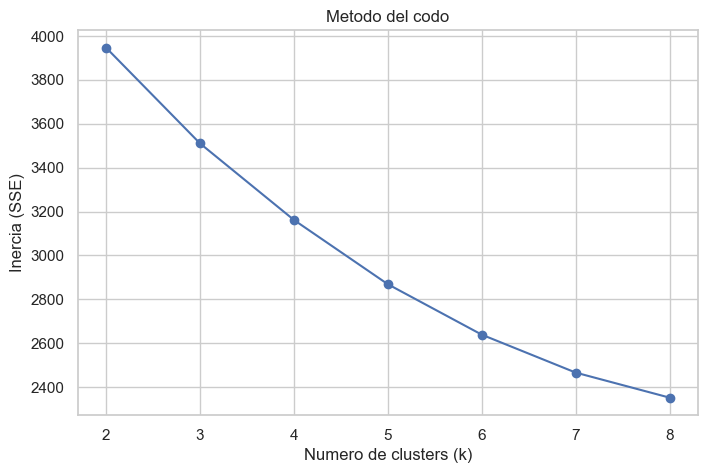

In [36]:
inertia = []
k_range = range(2, 9)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(list(k_range), inertia, marker="o")
plt.title("Metodo del codo")
plt.xlabel("Numero de clusters (k)")
plt.ylabel("Inercia (SSE)")
plt.xticks(list(k_range))
plt.show()


### Interpretacion del codo
Seleccionar un valor de k donde la curva pierde pendiente marcada (ejemplo: 3 o 4). Se fija k_opt manualmente con base en la grafica y conocimiento del negocio.
Se elige K=3 porque en el gráfico del codo hay una fuerte caída de SSE entre K=2 y K=3, la curva se estabiliza después de K=3 y 3 clusters es un número manejable para segmentar riesgo.

## 4. Entrenamiento de K-Means
- Ajuste del modelo con el k_opt elegido.
- Se agrega la etiqueta cluster al DataFrame de entrenamiento. No se utilizan datos de validacion o test.


In [37]:
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)

df_train["cluster"] = kmeans.fit_predict(X_scaled)
df_train["cluster"].value_counts().sort_index()


cluster
0    281
1    207
2    312
Name: count, dtype: int64

## 5. Analisis de clusters
- Perfil promedio por cluster en variables numericas.
- Tasa de default por cluster (solo para evaluar, no usada en el entrenamiento no supervisado).


In [38]:
cluster_profile = df_train.groupby("cluster")[num_cols].mean()
cluster_profile


,age,income,loan_amount,loan_income_ratio,num_late_payments,credit_score
cluster,,,,,,
0,45.436733,25916.810242,136104.249160,5.981861,0.722420,651.385826
1,42.860366,38814.742055,113939.311430,3.433987,2.603865,664.914112
2,45.296049,54572.740272,105034.425033,2.145176,0.631410,635.444245


In [39]:
if "default" in df_train.columns:
    cluster_default_rate = df_train.groupby("cluster")["default"].mean()
    print("Tasa de default por cluster:")
    display(cluster_default_rate)
else:
    print("Columna 'default' no encontrada; saltando tasa de default.")


Tasa de default por cluster:


cluster
0    0.124555
1    0.048309
2    0.003205
Name: default, dtype: float64

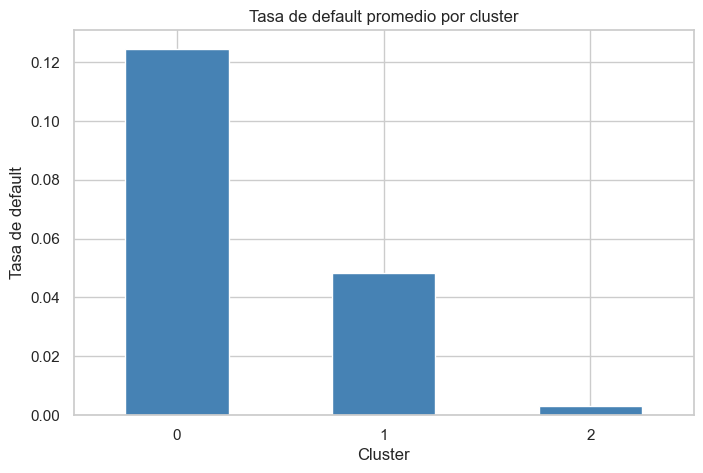

In [40]:
if "default" in df_train.columns:
    ax = df_train.groupby("cluster")["default"].mean().plot(kind="bar", color="steelblue")
    ax.set_ylabel("Tasa de default")
    ax.set_xlabel("Cluster")
    ax.set_title("Tasa de default promedio por cluster")
    plt.xticks(rotation=0)
    plt.show()


## 6. Interpretacion de clusters
Describir los perfiles observados (ejemplo):
- Cluster 0: mayor relacion deuda/ingreso y mas mora -> riesgo mas alto.
- Cluster 1: ingresos medios y morosidad moderada.
- Cluster 2: ingresos altos, pocas moras -> riesgo bajo.

El analisis complementa el modelo supervisado al revelar subsegmentos donde conviene ajustar politicas (precio, campanas, limites de credito) y priorizar monitoreo.


## 7. Conclusiones finales
- K-Means permite segmentar clientes sin usar la etiqueta default, evitando data leakage.
- La etiqueta cluster puede evaluarse como feature adicional en el modelo supervisado (reentrenar y validar antes de usar en produccion).
- Considerar recalibrar periodicamente, inicializaciones distintas y evaluar otras tecnicas (silhouette, DBSCAN, clustering jerarquico) en el futuro.
